<a href="https://colab.research.google.com/github/khanabdulmajid/Genrative-Adversarial-Networks-101/blob/main/DCGAN_for_small_color_photographs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [32]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.datasets.cifar10 import load_data
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, Reshape, LeakyReLU, BatchNormalization, Dense, Flatten, Dropout,Conv2DTranspose
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model

In [2]:
(trainX,trainy),(testX,testy) = load_data()
print(f"trainX shape = {trainX.shape}, trainy shape = {trainy.shape}")
print(f"testX shape = {testX.shape}, testy shape = {testy.shape}")

170498071/170498071 [==============================] - 10s 0us/step
trainX shape = (50000, 32, 32, 3), trainy shape = (50000, 1)
testX shape = (10000, 32, 32, 3), testy shape = (10000, 1)


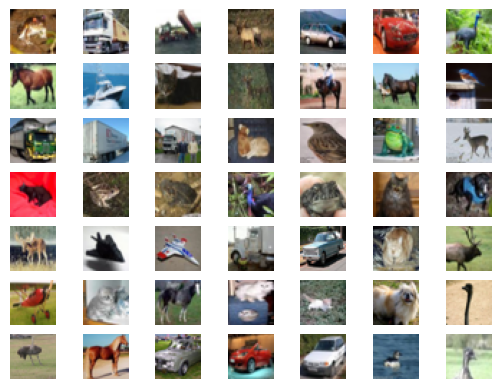

In [3]:
for i in range(49):
  # plt.figure(figsize=(210,210))
  plt.subplot(7,7,i+1)
  plt.axis('off')
  plt.imshow(trainX[i])

plt.show()

In [37]:
def define_discriminator(in_shape=(32,32,3)):
  model = Sequential()
  model.add(Conv2D(64, kernel_size = (3,3), padding='same', input_shape=in_shape))
  model.add(LeakyReLU(alpha = 0.2))

  model.add(Conv2D(128,kernel_size = (3,3),padding='same',strides=(2,2)))
  model.add(LeakyReLU(alpha = 0.2))

  model.add(Conv2D(128,kernel_size = (3,3),padding='same',strides=(2,2)))
  model.add(LeakyReLU(alpha = 0.2))

  model.add(Conv2D(256,kernel_size = (3,3),padding='same',strides=(2,2)))
  model.add(LeakyReLU(alpha = 0.2))

  model.add(Flatten())
  model.add(Dropout(0.4))
  model.add(Dense(1,activation='sigmoid'))

  opt= Adam(learning_rate=0.0002,beta_1=0.5)
  model.compile(loss= 'binary_crossentropy', optimizer = opt, metrics=['accuracy'])
  return model

def define_generator(latent_dim):
  model = Sequential()
  n_nodes = 256 * 4 * 4
  model.add(Dense(n_nodes,input_dim=latent_dim))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Reshape((4,4,256)))

  model.add(Conv2DTranspose(128, (4,4), strides = 2,padding='same'))
  model.add(LeakyReLU(alpha = 0.2))

  model.add(Conv2DTranspose(128, kernel_size = 4, strides = 2,padding='same'))
  model.add(LeakyReLU(alpha=0.2))

  model.add(Conv2DTranspose(128, kernel_size = 4, strides = 2, padding= 'same'))
  model.add(LeakyReLU(alpha= 0.2))

  model.add(Conv2D(3,(3,3),activation='tanh',padding='same'))

  return model










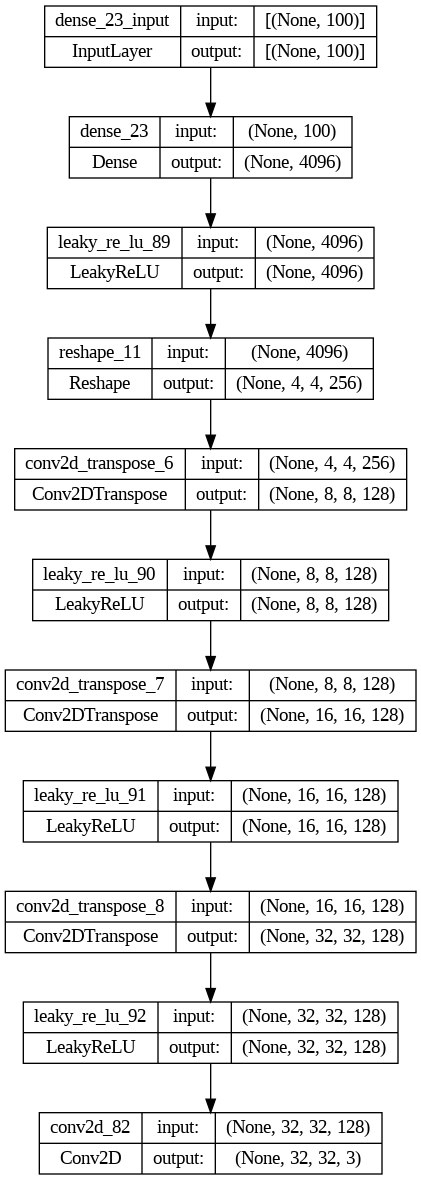

In [38]:
g_model= define_generator(100)
d_model=define_discriminator(in_shape=(32,32,3))
# gan_model = define_gan(g_model,d_model)
plot_model(g_model,show_shapes=True, show_layer_names=True)

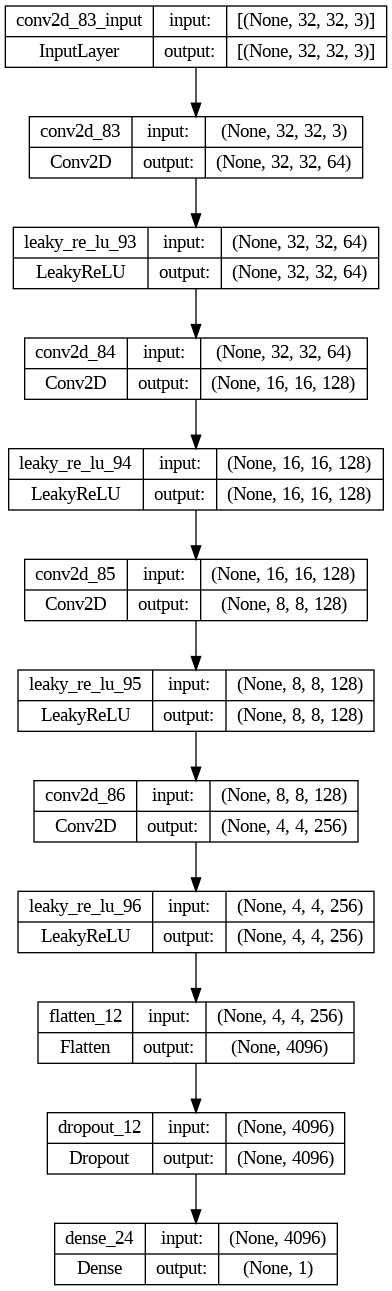

In [39]:
plot_model(d_model,show_shapes=True, show_layer_names=True)

In [47]:
def load_real_samples():
  (trainX,trainy),(testX,testy)=load_data()
  X=trainX.astype('float32')
  X=X-127.5/127.5
  return X

# load and prepare cifar10 training images
#this will later be updated
# def load_fake_samples(n_samples):
#   X = np.rand(32*32*n_samples) #generate fake samples
#   X = (X*2)-1 #[-1,1] # range of [-1,1] normalisation
#   X = X.reshape((n_samples,32,32,3))
#   y = np.zeros((n_samples,1))
#   return X, y

def generate_latent_points(latent_dim, n_samples):
  X = np.random.randn(latent_dim*n_samples)
  X = X.reshape((n_samples,latent_dim))
  return X


def generate_fake_samples(g_model,latent_dim, n_samples):
  X = generate_latent_points(latent_dim,n_samples)
  X = g_model.predict(X)
  y = np.zeros((n_samples,1))
  # print(f"X shape in gfe = {X.shape}")
  y = np.zeros((n_samples,1))

  return X,y

def generate_real_samples(dataset,n_samples):
  ix = np.random.randint(0,dataset.shape[0],n_samples)
  X = dataset[ix]
  y = np.ones((n_samples,1))
  # print(f"shapes in gre {X.shape}")
  return X,y



# def train_discriminator(model,dataset,n_iter,n_batch =256):
#   half_batch = n_batch/2
#   for i in range(n_iter):
#     X_real, y_real= generate_real_samples(dataset,half_batch)
#     _, acc_real = model.train_on_batch(X_real,y_real)

#     X_fake, y_fake = generate_fake_samples(half_batch)
#     _, acc_fake=model.train_on_batch(X_fake,y_fake)

#     print(f"epoch = {i+1}, real = {acc_real*100}%, fake = {acc_fake*100}")

def define_gan(g_model,d_model):
  d_model.trainable = False
  model = Sequential()
  model.add(g_model)
  model.add(d_model)
  opt = Adam(learning_rate=0.0002, beta_1=0.5)
  model.compile(loss='binary_crossentropy', optimizer=opt)
  return model

#evaluate the discriminator
def summarize_performance(epoch,g_model,d_model,latent_dim,n_samples):
  X_real,y_real = generate_real_samples(latent_dim,n_samples)
  _, acc_real = d_model.evaluate(X_real,y_real,verbose = 0)

  X_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_samples)
  _, acc_fake = d_model.evaluate(X_fake,y_fake)

  print('>Accuracy real: %.0f%%, fake: %.0f%%' % (acc_real*100, acc_fake*100))
  # save plot
  save_plot(X_fake, epoch)
  # save the generator model tile file
  filename = 'generator_model_%03d.h5' % (epoch+1)
  g_model.save(filename)

def save_plot(examples, epoch, n=7):
  # scale from [-1,1] to [0,1]
  examples = (examples + 1) / 2.0
  # plot images
  for i in range(n * n):
  # define subplot
    plt.subplot(n, n, 1 + i)
    # turn off axis
    plt.axis('off')
    # plot raw pixel data
    plt.imshow(examples[i])
  # save plot to file
  filename = 'generated_plot_e%03d.png' % (epoch+1)
  plt.savefig(filename)
  plt.close()





def train(g_model,d_model,gan_model,latent_dim,dataset,n_epochs=50,n_batch=128):
  half_batch = int(n_batch/2)
  bat_per_epo = int(dataset.shape[0]/n_batch)
  for i in range (n_epochs):
    for j in range(bat_per_epo):
      X_real,y_real = generate_real_samples(dataset, half_batch) # ACTUAL DATASET SAMPLES
      d_loss1, _ = d_model.train_on_batch(X_real,y_real) # fed to discriminator to train on

      X_fake,y_fake = generate_fake_samples(g_model, latent_dim, half_batch) #generator samples
      d_loss2, _ = d_model.train_on_batch(X_fake,y_fake) # fed to discriminator

      X_gan = generate_latent_points(latent_dim,half_batch)
      y_gan = np.ones((half_batch,1))
      g_loss = gan_model.train_on_batch(X_gan,y_gan)
      print('>%d, %d/%d, d1=%.3f, d2=%.3f g=%.3f' % (i+1, j+1, bat_per_epo, d_loss1, d_loss2, g_loss))

      if(i+1) % 10 ==0:
        summarize_performance(i,g_model,d_model,dataset,latent_dim)


In [46]:
latent_dim = 100
# create the discriminator
d_model = define_discriminator()
# create the generator
g_model = define_generator(latent_dim)
# create the gan
gan_model = define_gan(g_model, d_model)
# load image data
dataset = load_real_samples()
# train model
train(g_model, d_model, gan_model, latent_dim,dataset)

shapes in gre (64, 32, 32, 3)
2/2 [==============================] - 0s 184ms/step
X shape in gfe = (64, 32, 32, 3)
>1, 1/390, d1=6.107, d2=0.695 g=0.692
shapes in gre (64, 32, 32, 3)
2/2 [==============================] - 0s 171ms/step
X shape in gfe = (64, 32, 32, 3)
>1, 2/390, d1=0.000, d2=0.696 g=0.692
shapes in gre (64, 32, 32, 3)
2/2 [==============================] - 1s 415ms/step
X shape in gfe = (64, 32, 32, 3)
>1, 3/390, d1=0.000, d2=0.696 g=0.692
shapes in gre (64, 32, 32, 3)
2/2 [==============================] - 1s 294ms/step
X shape in gfe = (64, 32, 32, 3)
>1, 4/390, d1=0.000, d2=0.698 g=0.690
shapes in gre (64, 32, 32, 3)
2/2 [==============================] - 0s 188ms/step
X shape in gfe = (64, 32, 32, 3)
>1, 5/390, d1=0.000, d2=0.701 g=0.688
shapes in gre (64, 32, 32, 3)
2/2 [==============================] - 0s 172ms/step
X shape in gfe = (64, 32, 32, 3)
>1, 6/390, d1=0.000, d2=0.706 g=0.682
shapes in gre (64, 32, 32, 3)
2/2 [==============================] - 1s 308m

KeyboardInterrupt: 

In [42]:
dataset.shape

(50000, 32, 32, 3)

In [ ]:
model = define_discriminator((32,32,3))

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_26 (Conv2D)          (None, 32, 32, 64)        1792      
                                                                 
 leaky_re_lu_25 (LeakyReLU)  (None, 32, 32, 64)        0         
                                                                 
 conv2d_27 (Conv2D)          (None, 16, 16, 128)       73856     
                                                                 
 leaky_re_lu_26 (LeakyReLU)  (None, 16, 16, 128)       0         
                                                                 
 conv2d_28 (Conv2D)          (None, 8, 8, 128)         147584    
                                                                 
 leaky_re_lu_27 (LeakyReLU)  (None, 8, 8, 128)         0         
                                                                 
 conv2d_29 (Conv2D)          (None, 4, 4, 256)        

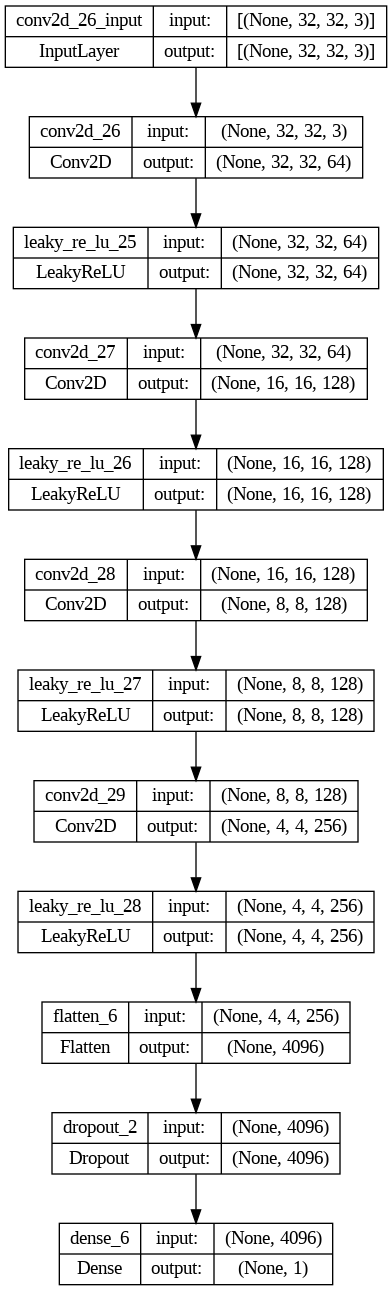

In [ ]:
model.summary()
plot_model(model,show_shapes=True,show_layer_names=True)